In [1]:
%pylab inline
from astropy.table import Table
from rnn_multiclass import RNNClassifier
import tensorflow as tf
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Loading dataset
data_table = Table.read('normalized_good.fits')

In [3]:
# Splitting training and testing data
np.random.seed(1234)
randomize_inds = range(len(data_table))
randomize_inds = permutation(randomize_inds)
randomized_inds_train = randomize_inds[0:15000]
randomized_inds_test  = randomize_inds[15000:]

In [4]:
randomized_inds_test[0:10]

array([16968, 10968,  1867,  9834,  6827,  2981,  3540,  4520, 17130,
        2679])

In [5]:
label_map = {-9:0, 1:1, 3:2, 21:3, 22:4, 23:5, 32:6, 33:7}

In [6]:
data_table['label'] =np.vectorize(label_map.get)(data_table['SNTYPE'].astype('int'))

In [7]:
len(label_map)

8

In [8]:
# Define input function for training 
def input_fn_train():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['label'][inds].astype('int32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32') 
        a,b,c =tf.py_func( extract_batch, [x], [tf.int32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        # Apply one hot encoding
        a = tf.one_hot(a, depth=8)
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train))
    dataset = dataset.repeat().shuffle(10000).batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

def input_fn_train_test():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['label'][inds].astype('int32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32')
        a,b,c =tf.py_func( extract_batch, [x], [tf.int32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        # Apply one hot encoding
        a = tf.one_hot(a, depth=8)
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

def input_fn_test():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_test[inds]
            return data_table['label'][inds].astype('int32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32') 
        a,b,c =tf.py_func( extract_batch, [x], [tf.int32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        # Apply one hot encoding
        a = tf.one_hot(a, depth=8)
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_test))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

In [9]:
#model = RNNClassifier(hidden_units=[128, 128], dropout=1, model_dir='tests/test_1')
#model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_2')
model = RNNClassifier(num_classes=8, hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_multiclass')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tests/test_multiclass', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2fef2a35f8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:
model.train(input_fn=input_fn_train, steps=1000)

INFO:tensorflow:Calling model_fn.
Tensor("IteratorGetNext:0", shape=(?, 8), dtype=float32, device=/device:CPU:0)
Tensor("fc/fc_3/BiasAdd:0", shape=(?, 8), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tests/test_multiclass/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into tests/test_multiclass/model.ckpt.
INFO:tensorflow:loss = 2.0862415, step = 0
INFO:tensorflow:global_step/sec: 7.17695
INFO:tensorflow:loss = 0.480084, step = 100 (13.935 sec)
INFO:tensorflow:global_step/sec: 7.58382
INFO:tensorflow:loss = 0.2883872, step = 200 (13.185 sec)
INFO:tensorflow:global_step/sec: 8.31824
INFO:tensorflow:loss = 0.29097754, step = 300 (12.021 sec)
INFO:tensorflow:global_step/sec: 7.99227
INFO:tensorflow:loss = 0.27801257, step = 400 (12.512 sec)
INFO:tensorflow:global_step/se

In [22]:
# Apply model to test set
test_prob = [p['prob'] for p in model.predict(input_fn_test)]
table_test = data_table[randomized_inds_test]
table_test['class'] = argmax(test_prob,axis=1)
table_test['p'] = np.max(test_prob,axis=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tests/test_multiclass/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [23]:
# Apply model to training set
train_prob = [p['prob'] for p in model.predict(input_fn_train_test)]
table_train = data_table[randomized_inds_train]
table_train['class'] = argmax(train_prob,axis=1)
table_train['p'] = np.max(train_prob,axis=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tests/test_multiclass/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [25]:
from sklearn.metrics import confusion_matrix

In [27]:
mat = confusion_matrix(table_train['label'], table_train['class'])

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[9.99427426e-01 5.72573719e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.95515695e-01 4.48430493e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.45454545e-01 5.45454545e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.79166667e-01 2.08333333e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.0

NameError: name 'itertools' is not defined

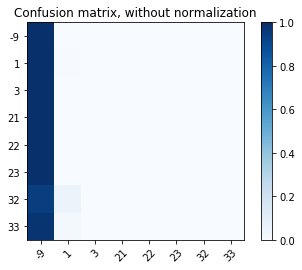

In [33]:
plot_confusion_matrix(mat, classes=[-9, 1, 3, 21, 22, 23, 32, 33],
                          normalize=True,
                      title='Confusion matrix, without normalization')